# Reproducing cell type analysis (Fig. 3):
- Set `DATA_PATH` to your local `scDRS_data_release_092121` folder (see below)
- We use the pre-computed numerical values in the Supp. tables to plot the figures.
- Alternatively curate the data using `job.celltype_association/summary_ct.ipynb`

In [1]:
import os, sys

%load_ext autoreload
%autoreload 2

import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from os.path import join
from statsmodels.stats.multitest import multipletests
from scipy.stats import rankdata
from tqdm import tqdm
from scipy import stats
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import scanpy as sc
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import scdrs

# Load data

In [2]:
DATA_PATH = "/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data_release_092121"

In [3]:
adata = sc.read_h5ad(
    join(DATA_PATH, "tabula_muris_senis/tabula-muris-senis-facs-official-raw-obj.h5ad")
)

SCORE_PATH = join(DATA_PATH, "score_file/score.tms_facs_with_cov.magma_10kb_1000")
URL_SUPP_TABLE = join(DATA_PATH, "supp_table/supp_tables.xlsx")

df_trait_info = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name=0,
)

df_celltype_info = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name=1,
)

# read results
df_ct_rls = pd.read_excel(URL_SUPP_TABLE, sheet_name="ST12 Results for TMS FACS")
dict_ct_rls = dict()
for n in ["prop-sig-cells", "ct-assoc-fdr", "heterogeneity-fdr"]:
    df_tmp = (
        df_ct_rls[["trait", "cell-type", n]]
        .pivot(index="trait", columns="cell-type", values=n)
        .loc[df_trait_info.Trait_Identifier.values, df_celltype_info.id.values]
    )
    df_tmp.index.name = None
    df_tmp.columns.name = None
    dict_ct_rls[n] = df_tmp

df_celltype_n_cell = adata.obs.cell_ontology_class.value_counts()
df_celltype_n_cell.index = [
    c.replace(" ", "_").replace(",", "") for c in df_celltype_n_cell.index
]


dict_celltype_name = {
    row.id: row.code for _, row in df_celltype_info.iterrows() if not pd.isna(row.code)
}

In [4]:
def small_squares(ax, pos, size=1, linewidth=0.8):
    """
    Draw many small squares on ax, given the positions of
    these squares.

    """
    for xy in pos:
        x, y = xy
        margin = (1 - size) / 2
        rect = patches.Rectangle(
            (x + margin, y + margin),
            size,
            size,
            linewidth=linewidth,
            edgecolor="k",
            facecolor="none",
            zorder=20,
        )
        ax.add_patch(rect)


def celltype_display_name(x):
    if x in dict_celltype_name:
        name = dict_celltype_name[x]
    else:
        name = x
    name += f" ({df_celltype_n_cell[x]})"
    name = name.replace("_", " ")
    name = name[0].upper() + name[1:]
    return name


def trait_display_name(x):
    dict_trait_name = {
        row.Trait_Identifier: row["Trait Name"] for _, row in df_trait_info.iterrows()
    }
    dict_trait_code = {
        row.Trait_Identifier: row["Code"] for _, row in df_trait_info.iterrows()
    }

    if dict_trait_name[x].lower() != dict_trait_code[x].lower():
        return f"{dict_trait_name[x]} ({dict_trait_code[x]})"
    else:
        return dict_trait_name[x]


def asterisk_display(x):
    if x < 0.05:
        return "×"
    else:
        return ""


def annotation_line(
    ax,
    xy1,
    xy2,
    text,
    linecolor="black",
    linewidth=1,
    fontsize=8,
    text_rotation=0,
    text_offset_x=0,
    text_offset_y=0,
    text_color="black",
):

    ax.annotate(
        "",
        xy=xy1,
        xytext=xy2,
        xycoords="data",
        textcoords="data",
        annotation_clip=False,
        arrowprops={"arrowstyle": "-", "color": linecolor, "linewidth": linewidth},
    )
    xcenter = (xy1[0] + xy2[0]) / 2
    ycenter = (xy1[1] + xy2[1]) / 2

    ax.annotate(
        text,
        xy=(xcenter + text_offset_x, ycenter + text_offset_y),
        ha="center",
        va="center",
        fontsize=fontsize,
        annotation_clip=False,
        rotation=text_rotation,
        weight="bold",
        color=text_color,
    )


def plot_diagonal_block(xs, ys, ax, linewidth=1, linestyle="--", color="black"):
    assert len(xs) == len(ys)
    start_x = 0
    start_y = 0
    for x, y in zip(xs, ys):
        ax.hlines(
            y=start_y,
            xmin=start_x,
            xmax=start_x + x,
            linewidth=linewidth,
            linestyle=linestyle,
            color=color,
        )
        ax.hlines(
            y=start_y + y,
            xmin=start_x,
            xmax=start_x + x,
            linewidth=linewidth,
            linestyle=linestyle,
            color=color,
        )
        ax.vlines(
            x=start_x,
            ymin=start_y,
            ymax=start_y + y,
            linewidth=linewidth,
            linestyle=linestyle,
            color=color,
        )
        ax.vlines(
            x=start_x + x,
            ymin=start_y,
            ymax=start_y + y,
            linewidth=linewidth,
            linestyle=linestyle,
            color=color,
        )
        start_x += x
        start_y += y

# Main figure

In [5]:
df_display = pd.read_excel(
    join(DATA_PATH, "supp_table/celltype-assoc-display.xlsx")
).dropna(how="all")
display_trait_list = df_display["trait"].dropna().values
display_celltype_list = df_display["celltype"].dropna().values

plot_order = dict()
for c, group in df_display.groupby("cluster"):
    plot_order[c] = (group.trait.dropna().values, group.celltype.dropna().values)

Number of traits / cell types in the analysis: (21, 20)
37 of 70 associations are heterogeneous


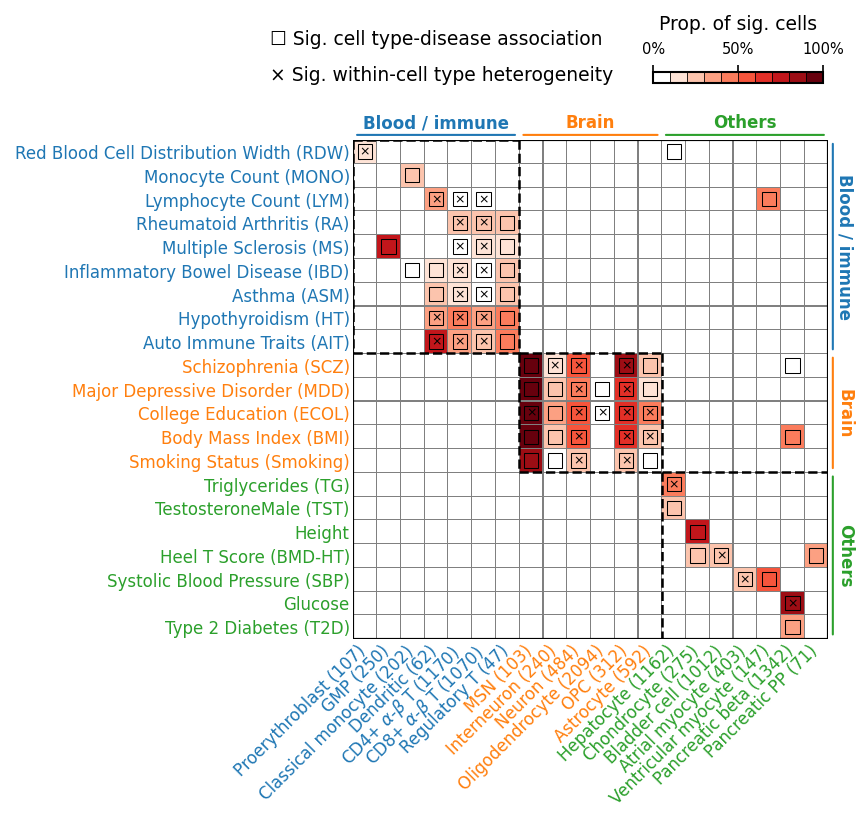

In [6]:
df_plot = (
    dict_ct_rls["prop-sig-cells"].loc[display_trait_list, display_celltype_list].copy()
)

df_plot.index.name = None
df_plot.columns.name = None

df_ct_fdr = (
    dict_ct_rls["ct-assoc-fdr"].loc[display_trait_list, display_celltype_list].copy()
)
df_hetero_fdr = (
    dict_ct_rls["heterogeneity-fdr"]
    .loc[display_trait_list, display_celltype_list]
    .copy()
)
print("Number of traits / cell types in the analysis:", df_plot.shape)


df_hetero_fdr = df_hetero_fdr.loc[df_plot.index, df_plot.columns].copy()

df_hetero_annot = df_hetero_fdr.applymap(asterisk_display)
df_hetero_annot[(df_ct_fdr > 0.05)] = ""

df_plot[df_ct_fdr > 0.05] = 0.0
df_plot = df_plot.rename(index=trait_display_name, columns=celltype_display_name)

print(
    f"{np.sum((df_hetero_annot == '×') & (df_ct_fdr <= 0.05)).sum()} of {np.sum(df_ct_fdr <= 0.05).sum()} associations are heterogeneous"
)

fig, ax = scdrs.util.plot_heatmap(
    df_plot,
    squaresize=27,
    heatmap_annot=df_hetero_annot,
    heatmap_annot_kws={"color": "black", "size": 6},
    heatmap_xticklabels=True,
    heatmap_yticklabels=True,
    heatmap_linecolor="gray",
    heatmap_linewidths=0.05,
    heatmap_cbar_kws=dict(
        use_gridspec=False,
        location="top",
        fraction=0.02,
        pad=0.1,
        drawedges=True,
        anchor=(0.9, 1.0),
        aspect=15,
    ),
    heatmap_vmin=0,
    heatmap_vmax=1.0,
    colormap_n_bin=10,
)

small_squares(
    ax,
    pos=[(y, x) for x, y in zip(*np.where(df_ct_fdr < 0.05))],
    size=0.6,
    linewidth=0.5,
)
cb = ax.collections[0].colorbar
cb.outline.set_edgecolor("black")
cb.outline.set_linewidth(1)
cb.ax.set_title("Prop. of sig. cells", fontsize=9)
cb.set_ticks([0, 0.5, 1.0])
cb.ax.set_xticklabels(["0%", "50%", "100%"], size=7)


# add bounding box
for x in ax.get_xlim():
    ax.axvline(x=x, color="k", linewidth=1)
    ax.axvline(x=x, color="k", linewidth=1)

for y in ax.get_ylim():
    ax.axhline(y=y, color="k", linewidth=1)
    ax.axhline(y=y, color="k", linewidth=1)

# add diagonal boxes
x_seps = [len(plot_order[c][0]) for c in plot_order]
y_seps = [len(plot_order[c][1]) for c in plot_order]
plot_diagonal_block(y_seps, x_seps, ax, linewidth=1.2)

dict_group_colors = {"Blood / immune": "C0", "Brain": "C1", "Others": "C2"}
# annotate cell-types
ct_breaks = np.cumsum([0] + y_seps)
for i, ct in enumerate(["Blood / immune", "Brain", "Others"]):
    annotation_line(
        ax=ax,
        text=ct,
        xy1=(ct_breaks[i], -0.2),
        xy2=(ct_breaks[i + 1], -0.2),
        text_offset_y=-0.5,
        linecolor=dict_group_colors[ct],
        text_color=dict_group_colors[ct],
    )
    for label in ax.xaxis.get_ticklabels()[ct_breaks[i] : ct_breaks[i + 1]]:
        label.set_color(dict_group_colors[ct])

# annotate traits
trait_breaks = np.cumsum([0] + x_seps)
for i, trait in enumerate(["Blood / immune", "Brain", "Others"]):

    annotation_line(
        ax=ax,
        text=trait,
        xy1=(ct_breaks[-1] + 0.2, trait_breaks[i]),
        xy2=(ct_breaks[-1] + 0.2, trait_breaks[i + 1]),
        text_rotation=270,
        text_offset_x=0.5,
        linecolor=dict_group_colors[trait],
        text_color=dict_group_colors[trait],
    )
    for label in ax.yaxis.get_ticklabels()[trait_breaks[i] : trait_breaks[i + 1]]:
        label.set_color(dict_group_colors[trait])

plt.text(-3.5, -4, "☐ Sig. cell type-disease association", fontsize=9)
plt.text(-3.5, -2.5, "× Sig. within-cell type heterogeneity", fontsize=9)
plt.show()

# Overview

In [7]:
df_plot = dict_ct_rls["prop-sig-cells"]

df_ct_fdr = dict_ct_rls["ct-assoc-fdr"].loc[df_plot.index, df_plot.columns].copy()

df_hetero_fdr = (
    dict_ct_rls["heterogeneity-fdr"].loc[df_plot.index, df_plot.columns].copy()
)

df_hetero_fdr_annot = df_hetero_fdr.applymap(asterisk_display)
df_hetero_fdr_annot[df_ct_fdr > 0.05] = ""
df_plot[df_ct_fdr > 0.05] = 0.0

df_plot = df_plot.rename(index=trait_display_name, columns=celltype_display_name)

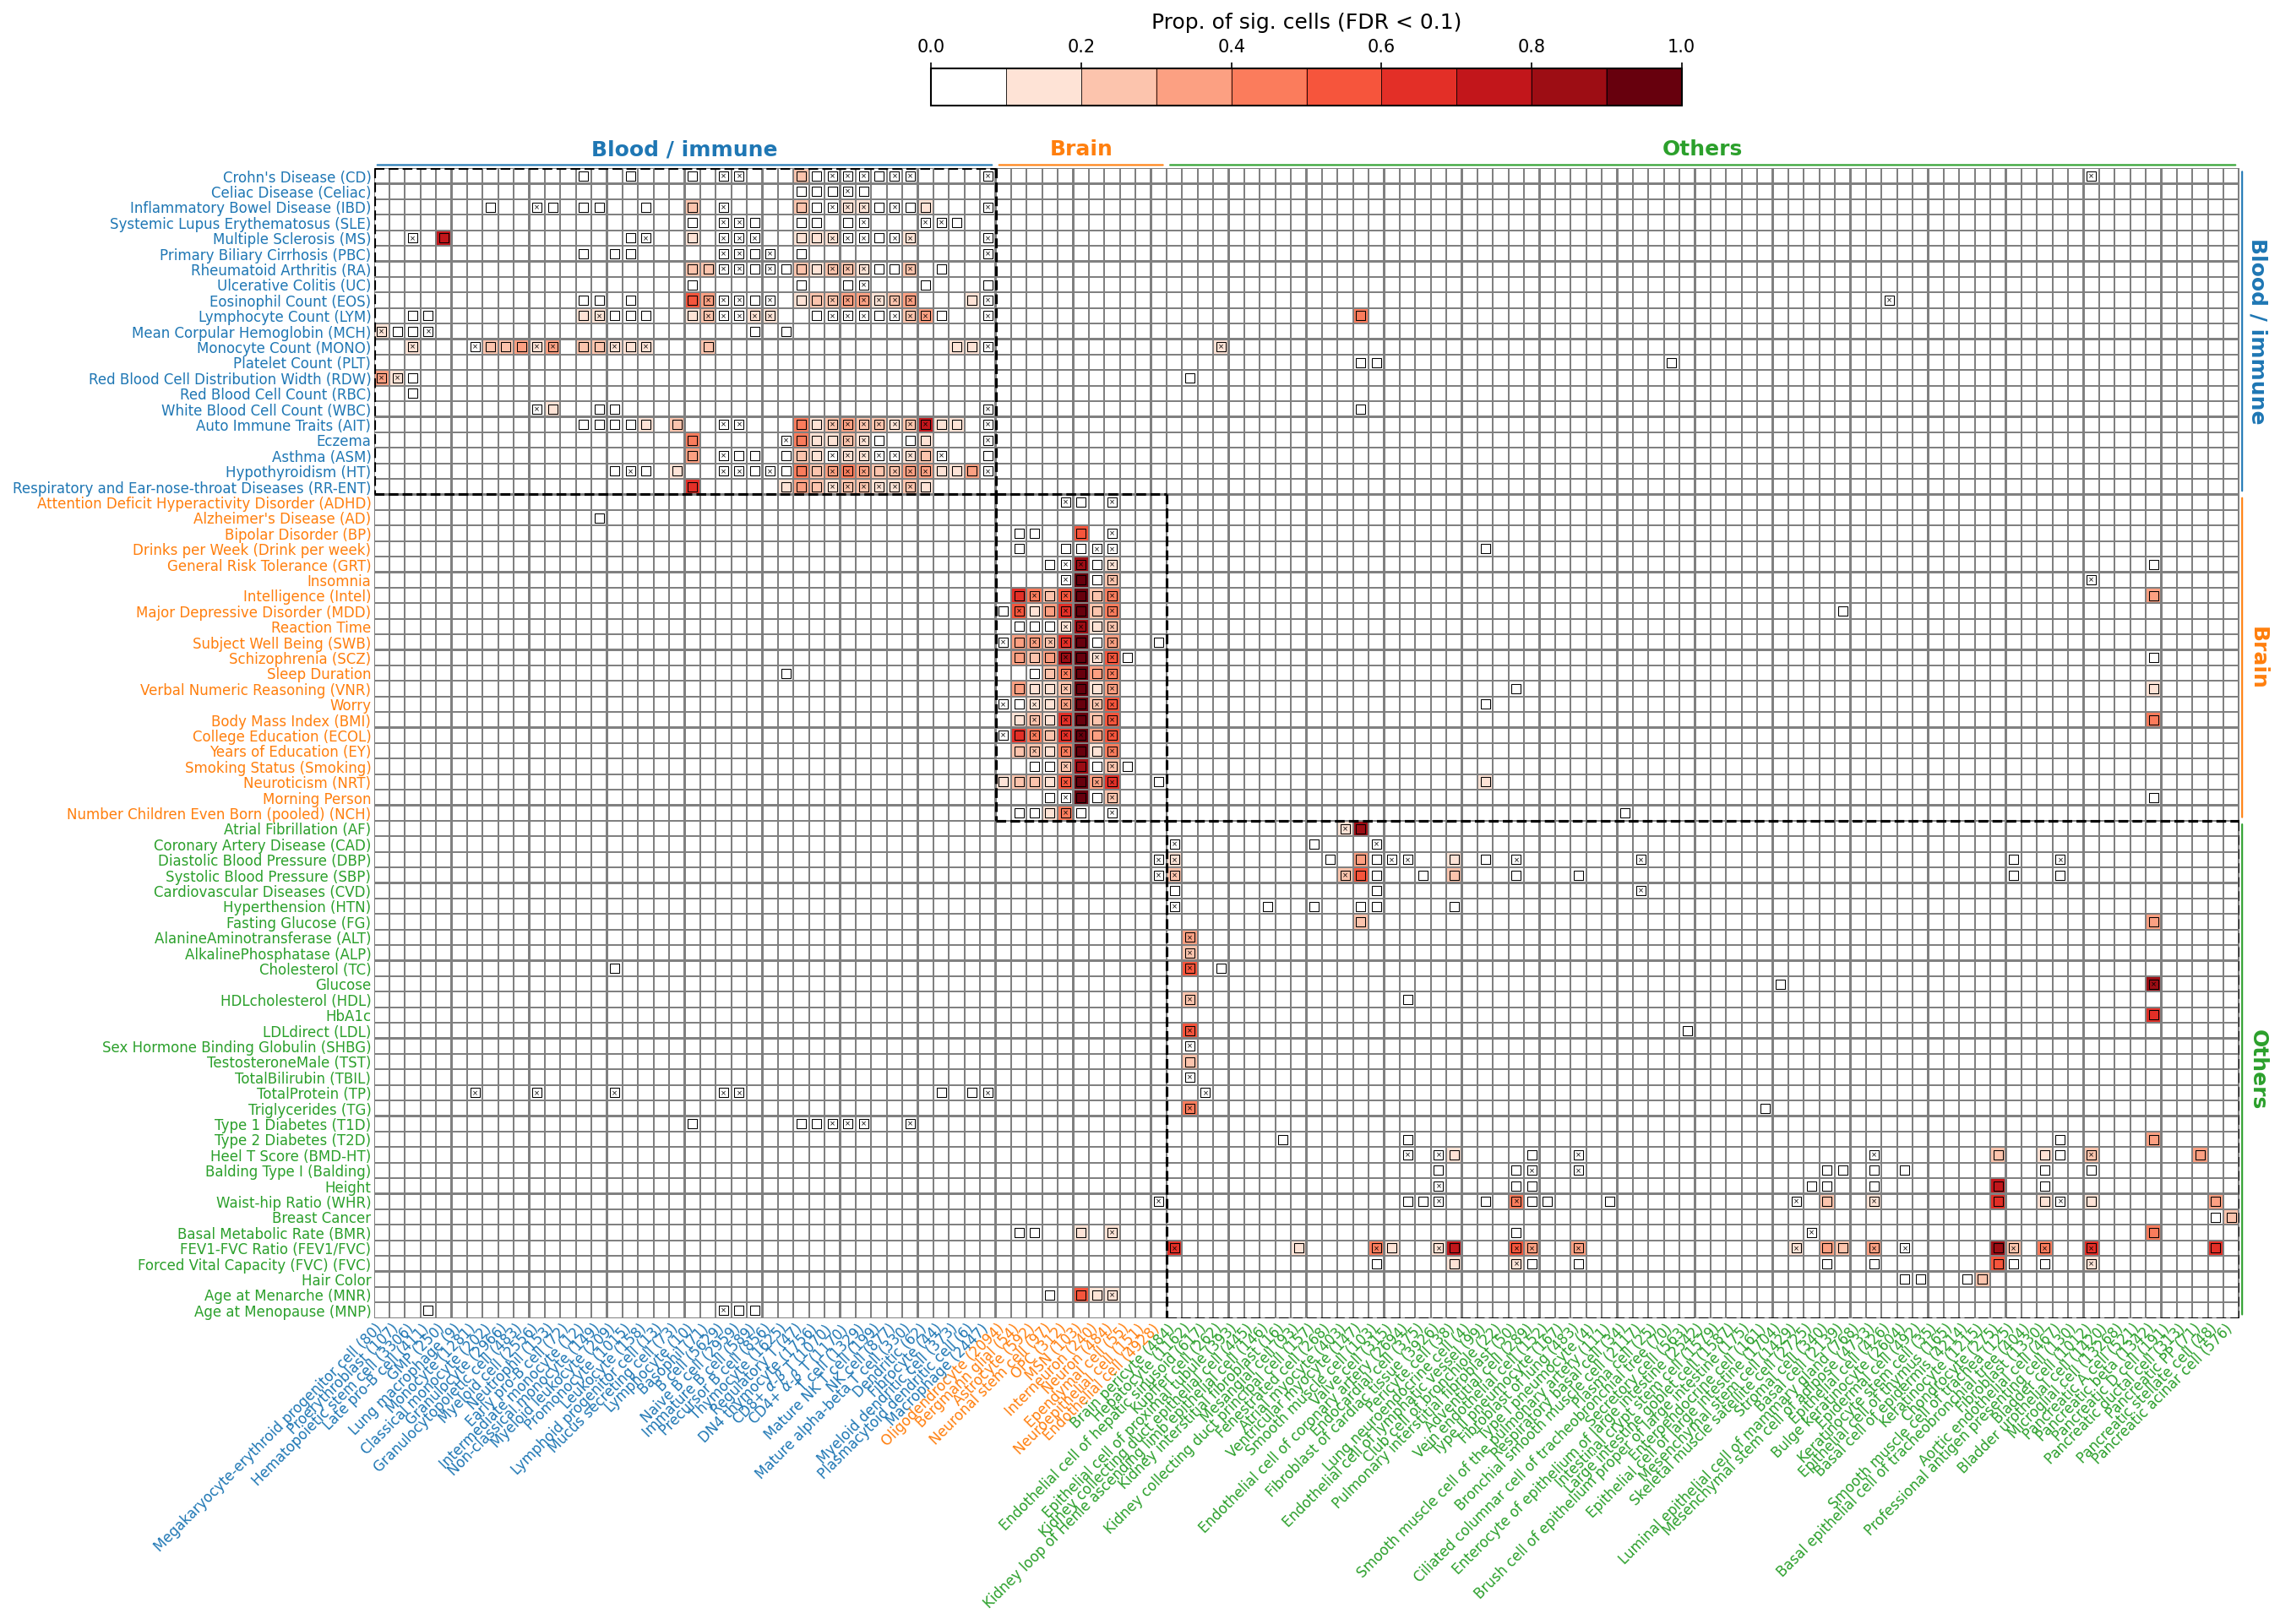

In [8]:
fig, ax = scdrs.util.plot_heatmap(
    df_plot,
    dpi=150,
    squaresize=20,
    heatmap_annot=df_hetero_fdr_annot,
    heatmap_annot_kws={"color": "black", "size": 4},
    heatmap_cbar_kws=dict(
        use_gridspec=False, location="top", fraction=0.03, pad=0.05, drawedges=True
    ),
    heatmap_vmin=0,
    heatmap_vmax=1,
    colormap_n_bin=10,
)
######### add small squares to show cell-type trait association ##########

small_squares(
    ax,
    pos=[(y, x) for x, y in zip(*np.where(df_ct_fdr < 0.05))],
    size=0.6,
    linewidth=0.5,
)

cb = ax.collections[0].colorbar
cb.ax.set_title("Prop. of sig. cells (FDR < 0.1)")
cb.outline.set_edgecolor("black")
cb.outline.set_linewidth(1)


# add diagonal boxes

x_seps = [
    df_trait_info.Category.isin(["blood/immune"]).sum(),
    df_trait_info.Category.isin(["brain"]).sum(),
    df_trait_info.Category.isin(["metabolic", "heart", "other"]).sum(),
]
y_seps = [
    df_celltype_info.category.isin(["blood", "immune"]).sum(),
    df_celltype_info.category.isin(["brain"]).sum(),
    df_celltype_info.category.isin(["others"]).sum(),
]


plot_diagonal_block(y_seps, x_seps, ax, linewidth=1.5)


dict_group_colors = {"Blood / immune": "C0", "Brain": "C1", "Others": "C2"}
# annotate cell-types
ct_breaks = np.cumsum([0] + y_seps)
for i, ct in enumerate(["Blood / immune", "Brain", "Others"]):
    annotation_line(
        ax=ax,
        text=ct,
        xy1=(ct_breaks[i], -0.2),
        xy2=(ct_breaks[i + 1], -0.2),
        text_offset_y=-1,
        linecolor=dict_group_colors[ct],
        text_color=dict_group_colors[ct],
        fontsize=12,
    )
    for label in ax.xaxis.get_ticklabels()[ct_breaks[i] : ct_breaks[i + 1]]:
        label.set_color(dict_group_colors[ct])

# annotate traits
trait_breaks = np.cumsum([0] + x_seps)
for i, trait in enumerate(["Blood / immune", "Brain", "Others"]):

    annotation_line(
        ax=ax,
        text=trait,
        xy1=(ct_breaks[-1] + 0.2, trait_breaks[i]),
        xy2=(ct_breaks[-1] + 0.2, trait_breaks[i + 1]),
        text_rotation=270,
        text_offset_x=1,
        linecolor=dict_group_colors[trait],
        text_color=dict_group_colors[trait],
        fontsize=12,
    )
    for label in ax.yaxis.get_ticklabels()[trait_breaks[i] : trait_breaks[i + 1]]:
        label.set_color(dict_group_colors[trait])
plt.show()

In [9]:
print(
    f"Out of all {df_ct_fdr.shape[0] * df_ct_fdr.shape[1]} cell type disease pairs, {(df_ct_fdr <= 0.05).sum().sum()} significant, {(df_hetero_fdr_annot == '×').sum().sum()} heterogenous"
)

print(
    f"{((df_ct_fdr < 0.05) & (df_hetero_fdr_annot == '×')).any(axis=1).sum()} out of {(df_ct_fdr < 0.05).any(axis=1).sum()} traits with a critical cell type has a significant heterogeneity cell-type"
)

Out of all 8880 cell type disease pairs, 577 significant, 247 heterogenous
65 out of 74 traits with a critical cell type has a significant heterogeneity cell-type


In [10]:
for trait_cat, ct_cat in zip(
    [["blood/immune"], ["brain"], ["metabolic", "heart", "other"]],
    [["blood", "immune"], ["brain"], ["others"]],
):
    df_hetero_fdr_annot_cat = df_hetero_fdr_annot.loc[
        df_trait_info.Category.isin(trait_cat).values,
        df_celltype_info.category.isin(ct_cat).values,
    ]
    df_ct_fdr_cat = df_ct_fdr.loc[
        df_trait_info.Category.isin(trait_cat).values,
        df_celltype_info.category.isin(ct_cat).values,
    ]
    print(
        f"{trait_cat}: number of  cell types: {df_ct_fdr_cat.shape[1]}, number of traits: {df_ct_fdr_cat.shape[0]}"
    )
    print(
        f"Number of significant cell type trait pair: {(df_ct_fdr_cat < 0.05).sum().sum()} / {df_ct_fdr_cat.shape[0] * df_ct_fdr_cat.shape[1]}"
    )

    print(
        f"Number of significant heterogeneity cell type trait pair: {(df_hetero_fdr_annot_cat == '×').sum().sum()} / {df_hetero_fdr_annot_cat.shape[0] * df_hetero_fdr_annot_cat.shape[1]}"
    )

['blood/immune']: number of  cell types: 40, number of traits: 21
Number of significant cell type trait pair: 249 / 840
Number of significant heterogeneity cell type trait pair: 120 / 840
['brain']: number of  cell types: 11, number of traits: 21
Number of significant cell type trait pair: 130 / 231
Number of significant heterogeneity cell type trait pair: 56 / 231
['metabolic', 'heart', 'other']: number of  cell types: 69, number of traits: 32
Number of significant cell type trait pair: 143 / 2208
Number of significant heterogeneity cell type trait pair: 51 / 2208
